In [6]:
pip install icecream

In [ ]:
pip install import-ipynb


In [ ]:
# import memory_saving_gradients

In [7]:
import os
import music21 as m21
import warnings
from icecream import ic
from tensorflow.keras.utils import to_categorical
import numpy as np
import json
from pprint import pprint

In [4]:
warnings.filterwarnings("ignore")

In [5]:
DATASET_PATH ='/content/drive/MyDrive/MelodyGeneration/sampleDataset'
PREPROCESSED_PATH ='/content/drive/MyDrive/MelodyGeneration/PPdataset'
SINGLE_FILE_DATASET_PATH ='/content/drive/MyDrive/MelodyGeneration/singleFileDataset'
NOTES_TO_INT_PATH ='/content/drive/MyDrive/MelodyGeneration/mappings/notes_to_int.json'
INT_TO_NOTES_PATH ='/content/drive/MyDrive/MelodyGeneration/mappings/int_to_notes.json'
ACCEPTABLE_DURATIONS = [0.25,0.5,0.75,1,2,3,4] #beats
SEQUENCE_LENGTH = 64

# PREPROCESSING


In [ ]:
def load_dataset(dataset_path)->list:
  songs=[]
  songs_name=[]
  for paths,subdires,files in os.walk(dataset_path):
    for file in files:
      song = m21.converter.parse(os.path.join(dataset_path,file))
      songs.append(song)
      songs_name.append(file[:-4])
    return songs,songs_name

In [ ]:
songs,songs_name = load_dataset(DATASET_PATH)

In [ ]:
def has_acceptable_duration(song,acceptable_durations) -> bool:
  for note in song.flatten().notesAndRests:
    if note.duration.quarterLength not in acceptable_durations:
      return False
    return True



In [ ]:
for i in range(len(songs)):
  ic(has_acceptable_duration(songs[i],ACCEPTABLE_DURATIONS))

In [ ]:
def transpose(song):
    #get the key of the song
    parts = song.getElementsByClass(m21.stream.Part) # there are 2 parts----->0 is right piano , 1 is left piano
    measure_part0= parts[0].getElementsByClass(m21.stream.Measure)
    key = measure_part0[0][4]

    #estimate key using music21
    if not isinstance(key,m21.key.Key):
      key = song.analyze('key')

    #getting the interval for transposition
    if key.mode == "major":
      interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    elif key.mode=="minor":
      interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('A'))

    #transposing song by calculated interval
    transposed_song = song.transpose(interval)
    return transposed_song

In [ ]:
def encode_song(song,time_step = 0.25):
  encoded_song = []
  for event in song.flatten().notesAndRests:
    # handling rest
    if isinstance(event,m21.note.Rest):
        symbol = "r"
    #handling notes

    elif isinstance(event,m21.note.Note):
      symbol = event.pitch.midi

    else :
        symbol = event[0].pitch.midi #60
      #handling rests

        #converting
    steps = int(event.duration.quarterLength/time_step)

    for step in range(steps):
        if step==0:
          encoded_song.append(symbol)
        else:
          encoded_song.append("_")

  #casting encoded song to a list
  encoded_song_str =" ".join(map(str,encoded_song))
  encoded_song_str.replace("r r","r")

  return encoded_song_str


In [ ]:
def load(file_path):
  with open(file_path,"r") as fp:
    song = fp.read()
  return song

In [ ]:
def preprocess(dataset_path):

  # loading the dataset
  print("loading Songs.......")
  songs,songs_name = load_dataset(dataset_path)
  print(f"loaded {len(songs)} songs.")

  #filtering out songs on the basis of the duration
  print("Filtering Songs")

  for i,song in enumerate(songs):
    filtered_songs = len(songs_name)

    if not has_acceptable_duration(song,ACCEPTABLE_DURATIONS):

      continue
  # transposing song?!
    song = transpose(song)
    filtered_songs = filtered_songs-1
  # Encoding these songs with music time series representation eg [60,"_","_","_",62,"_","_","_","_",62,"_",72,"_",70,"_",80,"r",........]
    encoded_song = encode_song(song)


  # saving the songs
    save_path = os.path.join(PREPROCESSED_PATH, str(songs_name[i]))
    with open(save_path, "w") as fp:
      fp.write(encoded_song)

  print(f"No. of songs filtered: {filtered_songs}/{len(songs_name)}")



In [ ]:
SEQUENCE_LENGTH = 64
def create_single_file_dataset(save_singleFileDataset_path,preprocessed_dataset,sequence_lenght):

  new_song_delimiter = "/ "* sequence_lenght
  songs = ""

  # loading encoded_song and add delimiters
  for path,_,files in os.walk(preprocessed_dataset):
    for file in files:
      file_path = os.path.join(preprocessed_dataset,file)
      song = load(file_path)
      songs = songs + song + " "+new_song_delimiter
      songs=songs[:]

    # saving the datset
  with open(os.path.join(save_singleFileDataset_path,"singleFileDataset.txt"),"w") as fp:
    fp.write(songs)

    return songs

In [ ]:
def create_mapping(songs):
  notes_to_int={}
  int_to_notes={}
  vocabulary = sorted(list(set(all_songs.split())))
  for i,symbol in enumerate(vocabulary):
    notes_to_int[symbol] = i

  for symbol,i in notes_to_int.items():
    int_to_notes[i]=symbol

  # saving vocab to a jason file
  with open(NOTES_TO_INT_PATH,"w") as fp:
    json.dump(notes_to_int,fp,indent=4)
  with open(INT_TO_NOTES_PATH,"w") as fp:
    json.dump(int_to_notes,fp,indent=4)
  return dict(notes_to_int),dict(int_to_notes)


In [ ]:
def convert_songs_to_int(songs):
  converted_songs_dataset=[]

  # # LOADING THE MAPPING JSON
  # with open(NOTES_TO_INT_PATH,"r") as fp:
  # notes_to_int = json.load(fp)
  songs = songs.split()
  for event in songs:
    converted_songs_dataset.append(notes_to_int[event])

  return converted_songs_dataset

In [ ]:
preprocess(DATASET_PATH)

In [ ]:

# merging all our dataset into a single file
all_songs=create_single_file_dataset(SINGLE_FILE_DATASET_PATH,PREPROCESSED_PATH,SEQUENCE_LENGTH)
print(all_songs)


In [ ]:
#mapping our notes
notes_to_int,int_to_notes = create_mapping(all_songs)
num_unique_notes = len(notes_to_int)
print(notes_to_int.items())

# Training Phase

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM,GRU,Dense,Dropout,Input,BatchNormalization, Attention
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

MODEL_PATH = '/content/drive/MyDrive/MelodyGeneration/Models/32datasetmodel'

In [ ]:
def generating_training_sequences(sequence_length):

  songs = load(os.path.join(SINGLE_FILE_DATASET_PATH,"singleFileDataset.txt"))
  int_songs = convert_songs_to_int(songs)
  unique_events = len(set(int_songs))

  inputs,targets=[],[]

  num_sequences = len(int_songs)-sequence_length

  for i in range(num_sequences):
    inputs.append(int_songs[i:i+sequence_length])  #input_dim-> num_sequences * sequence_length
    targets.append(int_songs[i+sequence_length])   #targets_dim-> num_sequences

  inputs= to_categorical(inputs,num_classes=unique_events)
  targets = np.array(targets)

  print(f"There are {len(inputs)} sequences.")
  return inputs,targets

# Using dropout inside the function parameter or outside?

You can use a Dropout(...) layer, it's not "wrong", but it will possibly drop "timesteps" too! (Unless you set noise_shape properly or use SpatialDropout1D, which is currently not documented yet)

Maybe you want it, maybe you dont. If you use the parameters in the recurrent layer, you will be applying dropouts only to the other dimensions, without dropping a single step. This seems healthy for recurrent layers, unless you want your network to learn how to deal with sequences containing gaps (this last sentence is a supposal).

Also, with the dropout parameters, you will be really dropping parts of the kernel as the operations are dropped "in every step", while using a separate layer will let your RNN perform non-dropped operations internally, since your dropout will affect only the final output.

In [8]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
def generate_model(units,output_size,model_type):
  match model_type:
    case "1lstm":
        input = Input(shape = (None,output_size),name = "INPUT_LAYER")
        lstm = LSTM(units=units , name = "LSTM_LAYER")(input)
        dropout = Dropout(0.2)(lstm)
        output = Dense(output_size,activation = "softmax", name="OUTPUT_LAYER")(dropout)
        model = keras.Model(input,output)
    case "2lstm_doubleD":
        input = Input(shape = (None,output_size),name = "INPUT_LAYER")
        lstm_1 = LSTM(units=units ,return_sequences= True, name = "LSTM_LAYER_1", dropout=0.2)(input)
        lstm_2 = LSTM(units=units , name = "LSTM_LAYER_2",dropout = 0.2)(lstm_1)

        output = Dense(output_size,activation = "softmax", name="OUTPUT_LAYER")(lstm_2)
        model = keras.Model(input,output)
    case "2gru" :
        input = Input(shape = (None,output_size),name = "INPUT_LAYER")
        gru_1 = GRU(units=units ,return_sequences= True, name = "GRU_LAYER_1")(input)
        gru_2 = GRU(units=units , name = "GRU_LAYER_2")(gru_1)
        dropout = Dropout(0.3)(gru_2)
        output = Dense(output_size,activation = "softmax", name="OUTPUT_LAYER")(dropout)
        model = keras.Model(input,output)

    case "mixed_model" :
      input = Input(shape = (None,output_size),name = "INPUT_LAYER")
      gru_1 = LSTM(units=units ,return_sequences= True, name = "GRU_LAYER_1")(input)

      lstm_2 = GRU(units=units , name = "LSTM_LAYER_2")(gru_1)
      dropout = Dropout(0.2)(lstm_2)


      output = Dense(output_size,activation = "softmax", name="OUTPUT_LAYER")(dropout)
      model = keras.Model(input,output)

    case "attentionGDL" :

        input = Input(shape = (None,output_size),name = "INPUT_LAYER")

        layer_1 = GRU(units=units ,return_sequences= True, name = "LSTM_LAYER_1")(input)
        layer_2 = Dropout(0.3)(layer_1)
        layer_3 =LSTM(units=units , name = "LSTM_LAYER_2")(layer_2)

        layer_4= Attention()([layer_3, layer_3])

        layer_5 = BatchNormalization()(layer_4)

        output = Dense(output_size,activation = "softmax", name="OUTPUT_LAYER")(layer_5)
        model = keras.Model(input,output)







  model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = Adam(learning_rate=0.001),
                metrics = ["accuracy"])
  model.summary()

  return model


In [ ]:
def load(file_path):
  with open(file_path,"r") as fp:
    song = fp.read()
  return song

In [ ]:
all_songs = load(os.path.join(SINGLE_FILE_DATASET_PATH,"singleFileDataset.txt"))

In [ ]:
notes_to_int,int_to_notes = create_mapping(all_songs)
num_unique_notes = len(notes_to_int)
print(notes_to_int.items())

In [ ]:
UNITS = 256
OUTPUT_SIZE = num_unique_notes = len(list(set(all_songs.split())))
EPOCHS = 50
BATCH_SIZE = 64


In [ ]:
model = generate_model(units = UNITS, output_size=OUTPUT_SIZE,model_type='attentionGDL')

In [ ]:
del model

In [ ]:
def train_model(epochs,batch_size,model_type):
# def train_model(x_train,y_train,epochs,batch_size,model_type):

  inputs,targets = generating_training_sequences(SEQUENCE_LENGTH)
  # ic(np.shape(inputs),np.shape(targets))

  model = generate_model(units=256, output_size = num_unique_notes,model_type= model_type)

  # model.fit(x_train,y_train,epochs = epochs , batch_size = batch_size)
  history=model.fit(inputs,targets,epochs = epochs , batch_size = batch_size)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['loss'])
  plt.show()

  model.save(os.path.join(MODEL_PATH,model_type+".h5"))

Shapes (None,) and (None, 64, 75) are incompatible

In [ ]:
inputs,targets = generating_training_sequences(SEQUENCE_LENGTH)

In [ ]:
del inputs,targets

In [ ]:
train_model(epochs = 64,batch_size = 64, model_type = "attentionGDL")

# Generating Melody

In [2]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(model.history['accuracy'])

In [1]:
import json

In [11]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 19.2 MB/s eta 0:00:00


In [21]:
import visualkeras


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [20]:
model = load_model(os.path.join(MODEL_PATH,"attentionGDLB.h5"))

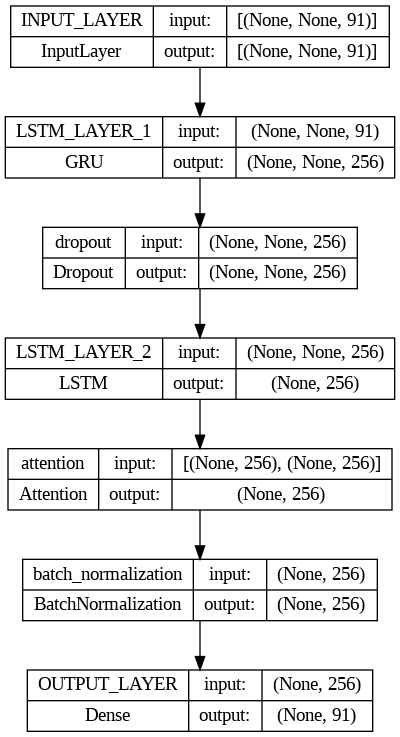

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)


In [ ]:
with open(NOTES_TO_INT_PATH,"r") as fp:
  notes_to_int = json.load(fp)

with open(INT_TO_NOTES_PATH,"r") as fp:
  int_to_notes = json.load(fp)

In [ ]:
model.summary()

In [ ]:
def generate_medlody(model,seed_sequence,start_symbol,num_steps,max_sequence_length,temperature):
  '''num_steps: No. of the steps in time series representation we want our generator to output,
  max_sequence_lenght : how many steps we want to consider in the seed for the network to be passed as the input(in our case its  64)'''
  def sample_with_temperature(probies, temp):

    prediction = np.log(probies)/ temp
    probies = np.exp(prediction)/np.sum(np.exp(prediction))
    choices = range(len(probies))
    return np.random.choice(choices,p = probies)



  with open(NOTES_TO_INT_PATH,"r") as fp:
    notes_to_int = json.load(fp)

  with open(INT_TO_NOTES_PATH,"r") as fp:
    int_to_notes = json.load(fp)

  seed_sequence = seed_sequence.split()
  melody = start_symbol + seed_sequence


  seed_sequence = [notes_to_int[symbol] for symbol in seed_sequence]

  for _ in range(num_steps):

    #taking all the last 64 steps as seed will be growing for num_steps steps
    seed_sequence = seed_sequence[-max_sequence_length:]


    #converting into one hot encoding as our model is trained using these
    onehot_seed = to_categorical(seed_sequence, num_classes = len(int_to_notes))

    #we need to add another dimension because predict() expects 3 dimensions as one dimension tells the batch size
    # in our case the batch size is 1 as we our passing just one sequence for prediction
    onehot_seed = np.reshape(onehot_seed,(1,len(seed_sequence),len(int_to_notes)))
    # onehot_seed = onehot_seed[np.newaxis(),...]
    # onehot_seed = np.expand_dims(onehot_seed, (1,len(seed_sequence),len(int_to_notes)))

    #making prediction     0.48 0.44 /0.7
    #now since we have batch size of 1,hence prediction will return list of lenght 1
    probabilities = model.predict(onehot_seed)[0] #[0.2,0.5,0.1,...] size = no. of unique notes  4-----[ [] ]
    #now we can return the index with the highest probability , but its a rigit choice
    #thus we gonna use temperature to bring these probability values closer aka scaling the distribution
    # temp->inf. ----- all the different values tend to have same value
    # tem->0 ------ all the values become deterministic highest value become 1 low 0
    # temp-> 1 ------ does nothing to the orignal distribution
    # intuition ==> value is directly proportional to predictibility of the sampling
    #  0 - deterministic inf. - random


    output_int = sample_with_temperature(probabilities,temperature)

    seed_sequence.append(output_int)

    # now we need to check if the output_int is "/"
    output_symbol = int_to_notes[str(output_int)]
    if output_symbol == "/":
      break
    melody.append(output_symbol)








  return melody


In [ ]:
def MelodyGenerator(model_path,model_type ,sequence_length,seed ):
  model = load_model(os.path.join(model_path,model_type))


  start_symbol = ["/"]* sequence_length

  melody=generate_medlody(model,seed_sequence=seed,
                    start_symbol=start_symbol,
                    num_steps=500,
                    max_sequence_length=sequence_length,
                    temperature=0.7)

  return melody




In [ ]:
seed = 'r _ _ _ _ _ _ _ _ _ _ _ 48 _ 48 _ 48 _ 48 _ 48 _ 48 _ 64 48 _ 65 48 _ 62 64 48 _ 65 66 _ _ _ _ _ 48 _ 48 _ 48 _ 67 _ _ _ _ _ _ 48 _ 48 _ 48 _ 48 _ 69 r 48 _ 66 67 48 _ 68 68 _ _' #string valu
print(dict(enumerate(seed.split())))


{0: 'r', 1: '_', 2: '_', 3: '_', 4: '_', 5: '_', 6: '_', 7: '_', 8: '_', 9: '_', 10: '_', 11: '_', 12: '48', 13: '_', 14: '48', 15: '_', 16: '48', 17: '_', 18: '48', 19: '_', 20: '48', 21: '_', 22: '48', 23: '_', 24: '64', 25: '48', 26: '_', 27: '65', 28: '48', 29: '_', 30: '62', 31: '64', 32: '48', 33: '_', 34: '65', 35: '66', 36: '_', 37: '_', 38: '_', 39: '_', 40: '_', 41: '48', 42: '_', 43: '48', 44: '_', 45: '48', 46: '_', 47: '67', 48: '_', 49: '_', 50: '_', 51: '_', 52: '_', 53: '_', 54: '48', 55: '_', 56: '48', 57: '_', 58: '48', 59: '_', 60: '48', 61: '_', 62: '69', 63: 'r', 64: '48', 65: '_', 66: '66', 67: '67', 68: '48', 69: '_', 70: '68', 71: '68', 72: '_', 73: '_'}


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = MelodyGenerator(MODEL_PATH,'2lstm.h5',SEQUENCE_LENGTH,seed)

In [ ]:
print(X)

# CONVERTING SEQUENCE INTO MIDI FILE

In [ ]:
X[67:]

In [ ]:
m21_event = m21.note.Note(int('52'),quarterLength = 0.25)
m21_event

In [ ]:
def save_melody(melody,step_duration = 0.25,format = "midi",savefile_path = "music.mid"):
# step_duration: "the amount of duration in a quater length
# that we have at each time step in our reperesentation"

# creating music21 Stream
# we would not be pushing time signature, parts or measures in our stream object
# keeping the things at default set by music21 , ps- ts is 4/4

  stream = m21.stream.Stream()


  #parsing and create note/rest
  #  60 _ _ _ r _ 55
  start_symbol= None #
  step_counter = 1 #its gona keep track of all the steps we have for a event
  #if a step counter is 4 than it would be called a quater lenght note, ie 1 beat duration ie a quarter_note

  for i,symbol in enumerate(melody[64:]):
    ic(i,symbol,start_symbol)
    #case of notes/rest
    if symbol !="_" or i+1 == len(melody[64:]):
      #but before dealing we want to ensure we are dealing with note/rest after the first one
      if start_symbol is not None:

        quarter_length_duration = step_duration*step_counter
        # ic(start_symbol)
        # ic(symbol)
        #handling rest
        if start_symbol=='r':
          m21_event = m21.note.Rest(length=quarter_length_duration)

        else:
          m21_event = m21.note.Note(int(start_symbol),quarterLength = quarter_length_duration) #number expressing the midi note corresponding to its pitch too

        stream.append(m21_event)
        step_counter = 1


      start_symbol = symbol
    else:
      step_counter +=1

  stream.write(format,savefile_path)












In [ ]:
print(X[64:85])

In [ ]:
print(X[64:][10:15])

In [ ]:
save_melody(X,savefile_path='/content/drive/MyDrive/MelodyGeneration/melodyyyy.mid')

# SCRIPTING SPACE FOR CODE TESTING

In [ ]:
print(len(X)-64-24)

In [ ]:

songs=[]
songs_name=[]
dataset_path = '/content/drive/MyDrive/MelodyGeneration/dataset/'
for paths,subdires,files in os.walk(dataset_path):
  for file in files[:5]:
    song = m21.converter.parse(os.path.join(dataset_path,file))
    songs.append(song)
    songs_name.append(file)

In [ ]:
test_song = songs[0]
print("has acceptable duration?", has_acceptable_duration(test_song,ACCEPTABLE_DURATIONS))

In [ ]:
parts = test_song.getElementsByClass(m21.stream.Part) # there are 2 parts----->0 is right piano , 1 is left piano
measure_part0= parts[0].getElementsByClass(m21.stream.Measure)
key = measure_part0[0][4]
# measure_part contains total number of measure in a music_piece
# for this test case we have 388 measure, offset is 3 (no. of beats in a bar) ie 3/4 time signature
print(f"No. of parts in this song are: {len(parts[:])}")
print("Key of the music measure is:",key)
print("predicted key after analyzing:" ,test_song.analyze('key'))

In [ ]:
!yes | add-apt-repository ppa:mscore-ubuntu/mscore3-stable
!apt install musescore3

In [ ]:
tsong= transpose(test_song)

# tsong.show()

In [ ]:
encoded_song = encode_song(tsong)
print(encoded_song)


In [ ]:
from pprint import pprint
encoded_song = encode_song(tsong,0.5)
# pprint(encoded_song)
encoded_song.replace("r r", "r")
# print(next(tsong.flat.notesAndRests[0].event.pitch.midi))


In [ ]:
# chord1 = m21.chord.Chord(['C4', 'E4', 'G4'])
# print(chord1.duration.quarterLength/0.25)